## CSCE-478/878 Final Project
### Human Activity Recognition using Smartphone Dataset
#### Kaustubh Gupta, Soon Leong Yeap, Nicholas Fong

#### Reference: https://machinelearningmastery.com/how-to-model-human-activity-from-smartphone-data/
#### http://chrisstrelioff.ws/sandbox/2015/06/25/decision_trees_in_python_again_cross_validation.html


In [1]:
# Imports
import warnings
import numpy as np
from numpy import unique
from numpy import array
from numpy import vstack
from pandas import read_csv
from pandas import DataFrame
from numpy import dstack
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict

In [2]:
## Loading Pre-Processed Feature Engineered Datasets

# load test labels file
x_train_fe = read_csv('HARDataset/train/X_train.txt', header=None, delim_whitespace=True) 
x_train_fe = x_train_fe.values
# load test labels file
x_test_fe = read_csv('HARDataset/test/X_test.txt', header=None, delim_whitespace=True) 
x_test_fe = x_test_fe.values
# load train labels file
y_train_fe = read_csv('HARDataset/train/y_train.txt', header=None, delim_whitespace=True) 
y_train_fe = y_train_fe.values
# load test labels file
y_test_fe = read_csv('HARDataset/test/y_test.txt', header=None, delim_whitespace=True) 
y_test_fe = y_test_fe.values

print(x_train_fe.shape, "and", y_train_fe.shape, "and" , x_test_fe.shape ,"and", y_test_fe.shape)
# flatten y
y_train_fe = y_train_fe[:,0]
y_test_fe = y_test_fe[:,0]
print(x_train_fe.shape, "and", y_train_fe.shape, "and" , x_test_fe.shape ,"and", y_test_fe.shape)


(7352, 561) and (7352, 1) and (2947, 561) and (2947, 1)
(7352, 561) and (7352,) and (2947, 561) and (2947,)


In [3]:
## Loading Only Pre-Processed Raw Datasets

y_train_raw = y_train_fe
y_test_raw = y_test_fe

files_test = ['HARDataset/test/Inertial Signals/body_acc_x_test.txt', 
          'HARDataset/test/Inertial Signals/body_acc_y_test.txt',
          'HARDataset/test/Inertial Signals/body_acc_z_test.txt',
          'HARDataset/test/Inertial Signals/body_gyro_x_test.txt',
          'HARDataset/test/Inertial Signals/body_gyro_y_test.txt',
          'HARDataset/test/Inertial Signals/body_gyro_z_test.txt',
          'HARDataset/test/Inertial Signals/total_acc_x_test.txt', 
          'HARDataset/test/Inertial Signals/total_acc_y_test.txt', 
          'HARDataset/test/Inertial Signals/total_acc_z_test.txt']

files_train = ['HARDataset/train/Inertial Signals/body_acc_x_train.txt', 
          'HARDataset/train/Inertial Signals/body_acc_y_train.txt',
          'HARDataset/train/Inertial Signals/body_acc_z_train.txt',
          'HARDataset/train/Inertial Signals/body_gyro_x_train.txt',
          'HARDataset/train/Inertial Signals/body_gyro_y_train.txt',
          'HARDataset/train/Inertial Signals/body_gyro_z_train.txt',
          'HARDataset/train/Inertial Signals/total_acc_x_train.txt', 
          'HARDataset/train/Inertial Signals/total_acc_y_train.txt', 
          'HARDataset/train/Inertial Signals/total_acc_z_train.txt']

loaded_files_test = list()
loaded_files_train = list()

for name in files_train:
    file_data = read_csv(name, header=None, delim_whitespace=True)
    file_data = file_data.values
    loaded_files_train.append(file_data)
loaded_files_train = dstack(loaded_files_train)
x_train_raw = loaded_files_train.reshape((loaded_files_train.shape[0], 
          loaded_files_train.shape[1] * loaded_files_train.shape[2]))

print(x_train_raw.shape, y_train_raw.shape)

for name in files_test:
    file_data = read_csv(name, header=None, delim_whitespace=True)
    file_data = file_data.values
    loaded_files_test.append(file_data)
loaded_files_test = dstack(loaded_files_test)
x_test_raw = loaded_files_test.reshape((loaded_files_test.shape[0], 
         loaded_files_test.shape[1] * loaded_files_test.shape[2]))

print(x_test_raw.shape, y_test_raw.shape)

(7352, 1152) (7352,)
(2947, 1152) (2947,)


In [4]:
# summarize the balance of classes in an output variable column
def class_breakdown(data):
    # convert the numpy array into a dataframe
    df = DataFrame(data)
    # group data by the class value and calculate the number of rows
    counts = df.groupby(0).size()
    # retrieve raw rows
    counts = counts.values
    # summarize
    for i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))

# summarize class breakdown
print("Train Dataset Summary:")
class_breakdown(y_train_fe)
print()
print("Test Dataset Summary:")
class_breakdown(y_test_fe)

Train Dataset Summary:
Class=1, total=1226, percentage=16.676
Class=2, total=1073, percentage=14.595
Class=3, total=986, percentage=13.411
Class=4, total=1286, percentage=17.492
Class=5, total=1374, percentage=18.689
Class=6, total=1407, percentage=19.138

Test Dataset Summary:
Class=1, total=496, percentage=16.831
Class=2, total=471, percentage=15.982
Class=3, total=420, percentage=14.252
Class=4, total=491, percentage=16.661
Class=5, total=532, percentage=18.052
Class=6, total=537, percentage=18.222


In [5]:
print("Describe Feature Engineered x_train:")
DataFrame(x_train_fe).describe()

Describe Feature Engineered x_train:


,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.250994,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.023692,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,0.134000,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,0.289096,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000


In [6]:
print("Describe Raw x_train:")
DataFrame(x_train_raw).describe()

Describe Raw x_train:


,0,1,2,3,4,5,6,7,8,9,...,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,-0.003374,-0.000437,0.004856,-0.000707,0.009055,0.003162,0.804024,0.027620,0.090438,-0.002858,...,0.087553,0.001978,-0.002557,0.001282,-0.003504,0.001459,0.003617,0.806415,0.026274,0.087522
std,0.198317,0.125660,0.111204,0.418437,0.374442,0.258786,0.414103,0.390980,0.356996,0.197407,...,0.359282,0.199408,0.121517,0.105263,0.411174,0.372364,0.257599,0.417875,0.392548,0.358952
min,-0.857863,-0.890609,-0.797215,-2.945864,-2.853085,-2.216418,-0.405665,-1.131754,-1.206339,-0.897771,...,-1.158892,-0.795426,-0.994173,-0.719086,-3.658334,-2.651202,-2.192251,-0.411995,-1.297008,-1.147546
25%,-0.038449,-0.012259,-0.014686,-0.052254,-0.054155,-0.031872,0.665270,-0.222442,-0.126715,-0.037463,...,-0.133852,-0.023289,-0.009988,-0.013037,-0.043289,-0.046645,-0.020614,0.657181,-0.227482,-0.131867
50%,-0.000718,0.000669,0.000566,0.000207,0.000530,0.000400,0.953989,-0.083841,0.047347,-0.000747,...,0.042358,-0.000622,0.000503,0.000274,-0.000372,-0.000223,0.000506,0.956491,-0.085488,0.041329
75%,0.008661,0.026403,0.025860,0.073247,0.056535,0.063529,1.019297,0.182420,0.244732,0.008745,...,0.243678,0.006828,0.016794,0.016118,0.040510,0.032087,0.042660,1.019425,0.188911,0.241278
max,1.133144,0.742966,0.722546,2.570758,3.528782,1.671485,2.104388,1.134527,1.158310,1.091050,...,0.994003,1.087837,0.751092,0.777403,4.077152,3.610321,1.898607,2.060867,1.024147,0.986860


In [7]:
print("Describe Feature Engineered x_test:")
DataFrame(x_test_fe).describe()

Describe Feature Engineered x_test:


,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
count,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,...,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000
mean,0.273996,-0.017863,-0.108386,-0.613635,-0.508330,-0.633797,-0.641278,-0.522676,-0.637038,-0.462063,...,0.130236,-0.277593,-0.598756,0.005264,0.003799,0.040029,-0.017298,-0.513923,0.074886,-0.048720
std,0.060570,0.025745,0.042747,0.412597,0.494269,0.362699,0.385199,0.479899,0.357753,0.523916,...,0.231018,0.317245,0.311042,0.336147,0.445077,0.634989,0.501311,0.509205,0.324300,0.241467
min,-0.592004,-0.362884,-0.576184,-0.999606,-1.000000,-0.998955,-0.999417,-0.999914,-0.998899,-0.952357,...,-0.785543,-1.000000,-1.000000,-1.000000,-0.993402,-0.998898,-0.991096,-0.984195,-0.913704,-0.949228
25%,0.262075,-0.024961,-0.121162,-0.990914,-0.973664,-0.976122,-0.992333,-0.974131,-0.975352,-0.934447,...,-0.008433,-0.517494,-0.829593,-0.130541,-0.282600,-0.518924,-0.428375,-0.829722,0.022140,-0.098485
50%,0.277113,-0.016967,-0.108458,-0.931214,-0.790972,-0.827534,-0.937664,-0.799907,-0.817005,-0.852659,...,0.142676,-0.311023,-0.683672,0.005188,0.006767,0.047113,-0.026726,-0.729648,0.181563,-0.010671
75%,0.288097,-0.010143,-0.097123,-0.267395,-0.105919,-0.311432,-0.321719,-0.133488,-0.322771,-0.009965,...,0.288320,-0.083559,-0.458332,0.146200,0.288113,0.622151,0.394387,-0.545939,0.260252,0.092373
max,0.671887,0.246106,0.494114,0.465299,1.000000,0.489703,0.439657,1.000000,0.427958,0.786436,...,1.000000,1.000000,1.000000,0.998898,0.986347,1.000000,1.000000,0.833180,1.000000,0.973113


In [8]:
print("Describe Raw x_test:")
DataFrame(x_test_raw).describe()

Describe Raw x_test:


,0,1,2,3,4,5,6,7,8,9,...,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151
count,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,...,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000
mean,-0.006010,0.002069,-0.000035,-0.022174,0.005763,0.006299,0.814318,0.005890,0.079570,-0.006135,...,0.077130,-0.001101,-0.002393,-0.003909,0.000880,-0.002564,0.003834,0.815649,0.002063,0.076800
std,0.179975,0.122536,0.096707,0.411938,0.338274,0.249661,0.401726,0.410387,0.306838,0.180451,...,0.311302,0.182166,0.118690,0.095463,0.418575,0.331976,0.244056,0.405799,0.413539,0.311484
min,-0.756142,-0.832132,-0.655501,-2.352782,-2.528342,-1.862215,-0.245473,-1.112589,-1.015800,-0.714654,...,-1.084465,-0.639273,-0.825868,-0.637227,-2.946578,-1.917106,-2.116511,-0.244237,-1.005888,-1.106173
25%,-0.055157,-0.012583,-0.019014,-0.099014,-0.070310,-0.034640,0.718966,-0.223227,-0.091864,-0.053574,...,-0.093774,-0.042880,-0.011327,-0.017765,-0.051193,-0.059340,-0.021817,0.718473,-0.239130,-0.093099
50%,-0.001285,0.001453,0.000064,-0.001649,-0.000707,0.001479,0.955635,-0.079844,0.041105,-0.001276,...,0.042738,-0.000981,0.000785,0.000047,-0.000767,-0.000756,0.001584,0.957891,-0.087373,0.042558
75%,0.007039,0.037252,0.019670,0.062376,0.054005,0.070470,1.019784,0.134872,0.198927,0.007759,...,0.199065,0.006215,0.021300,0.014149,0.054556,0.037908,0.047773,1.019713,0.139899,0.199418
max,1.071047,0.600451,0.687682,1.862086,2.444461,1.786059,1.964238,1.090686,0.975834,1.056747,...,0.986690,1.053488,0.443897,0.482820,3.293090,2.369893,1.312065,2.018431,1.026405,0.980211


# All the plots 

In [9]:
# load a single file as a numpy array
def load_file(filepath):
    df = read_csv(filepath, delim_whitespace=True)
    return df.values

# load a list of files
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group
def load_dataset(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = list()
    
    # total acceleration
    filenames += ['total_acc_x_' + group + '.txt', 'total_acc_y_' + group + '.txt', 'total_acc_z_' + group + '.txt']
    # body acceleration
    filenames += ['body_acc_x_' + group + '.txt', 'body_acc_y_' + group + '.txt', 'body_acc_z_' + group + '.txt']
    # body gyroscope
    filenames += ['body_gyro_x_' + group + '.txt', 'body_gyro_y_' + group + '.txt', 'body_gyro_z_' + group + '.txt']
    
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_' + group + '.txt')
    
    return X, y

# all data for one subject
def data_for_subject(X, y, subject_map, subject_id):
    # get row indexes for the subject id
    rowIndex = [i for i in range(len(subject_map)) if subject_map[i]==subject_id]
    # return the selected samples
    return X[rowIndex, :, :], y[rowIndex]

# convert a series of windows to a 1D list
def to_series(windows):
    series = list()
    for window in windows:
        # remove the overlap from the window
        half = int(len(window) / 2) - 1
        for value in window[-half:]:
            series.append(value)
    return series

## plot histograms per activity for a subject
# group data by activity
def data_by_activity(X, y, activities):
    # group windows by activity
    return {a:X[y[:,0]==a, :, :] for a in activities}


##load training dataset
X, y = load_dataset('train', 'HARDataset/')
# load mapping of rows to subjects
subject_map = load_file('HARDataset/train/subject_train.txt')

<ipython-input-10-642f94e83cf0>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes_subplot = plt.subplot(n, 1, i+1, sharex=x_axis)


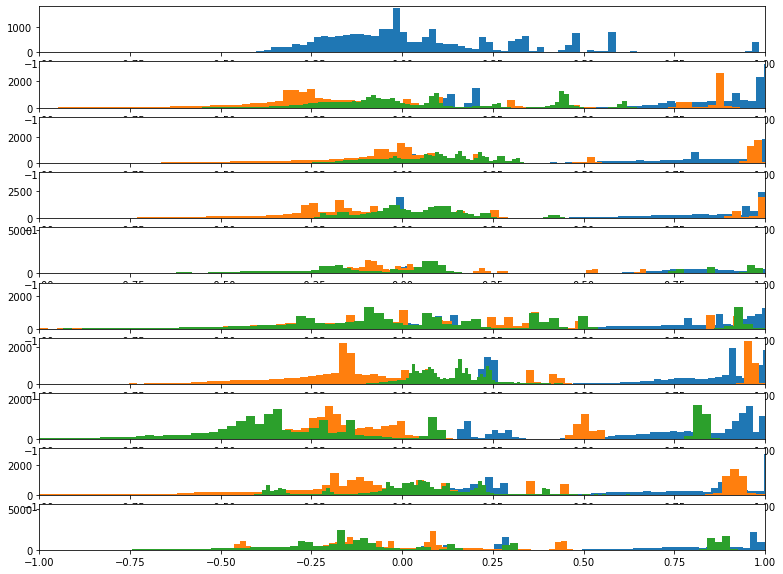

In [10]:
# plot histograms for multiple subjects
# for total acceleration data
def plot_subject_histograms(X, y, sub_map, n=10):
    plt.figure(figsize=(13, 10))
    # get unique subjects
    subjects = unique(sub_map[:,0])
    # enumerate subjects
    x_axis = None
    for i in range(n):
        subject_id = subjects[i]
        # get data for one subject
        subjectData, _ = data_for_subject(X, y, sub_map, subject_id)
        # total acc
        for j in range(3):
            axes_subplot = plt.subplot(n, 1, i+1, sharex=x_axis)
            axes_subplot.set_xlim(-1,1)
            if i == 0:
                 x_axis = axes_subplot
            plt.hist(to_series(subjectData[:,:,j]), bins=100)
    plt.show()

# plot histograms for subjects
plot_subject_histograms(X, y, subject_map)

<ipython-input-11-b4b87d11b9d8>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes_subplot = plt.subplot(n, 1, i+1, sharex=x_axis)


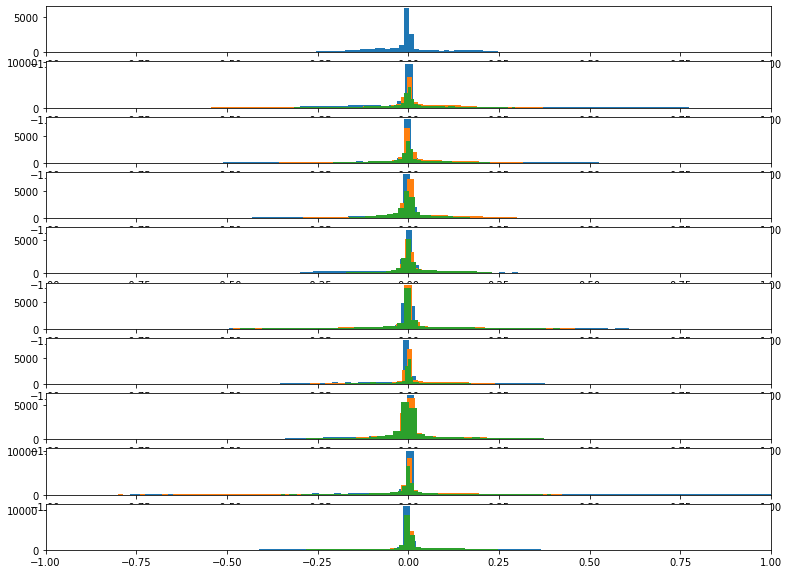

In [11]:
# plot histograms for multiple subjects
# for body acceleration data
def plot_subject_histograms(X, y, sub_map, n=10):
    plt.figure(figsize=(13,10))
    # get unique subjects
    subjects = unique(sub_map[:,0])
    # enumerate subjects
    x_axis = None
    for i in range(n):
        subject_id = subjects[i]
        # get data for one subject
        subjectData, _ = data_for_subject(X, y, sub_map, subject_id)
        # body acc
        for j in range(3):
            axes_subplot = plt.subplot(n, 1, i+1, sharex=x_axis)
            axes_subplot.set_xlim(-1,1)
            if i == 0:
                x_axis = axes_subplot
            plt.hist(to_series(subjectData[:,:,3+j]), bins=100)
    plt.show()

# plot histograms for subjects
plot_subject_histograms(X, y, subject_map)

<ipython-input-12-5db8aa469b2f>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes_subplot = plt.subplot(n, 1, i+1, sharex=x_axis)


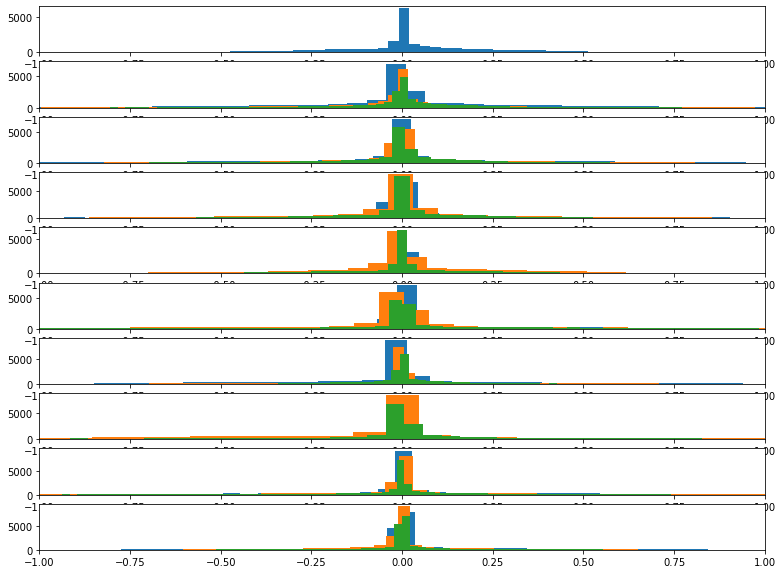

In [12]:
# plot histograms for multiple subjects
# for gyroscopic data
def plot_subject_histograms(X, y, sub_map, n=10):
    plt.figure(figsize=(13,10))
    # get unique subjects
    subjects = unique(sub_map[:,0])
    # enumerate subjects
    x_axis = None
    for i in range(n):
        subject_id = subjects[i]
        # get data for one subject
        subjectData, _ = data_for_subject(X, y, sub_map, subject_id)
        # body acc
        for j in range(3):
            axes_subplot = plt.subplot(n, 1, i+1, sharex=x_axis)
            axes_subplot.set_xlim(-1,1)
            if i == 0:
                x_axis = axes_subplot
            plt.hist(to_series(subjectData[:,:,6+j]), bins=100)
    plt.show()


# plot histograms for subjects
plot_subject_histograms(X, y, subject_map)

<ipython-input-13-de82ed4a2ad7>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes_subplot = plt.subplot(len(activity), 1, i+1, sharex=x_axis)


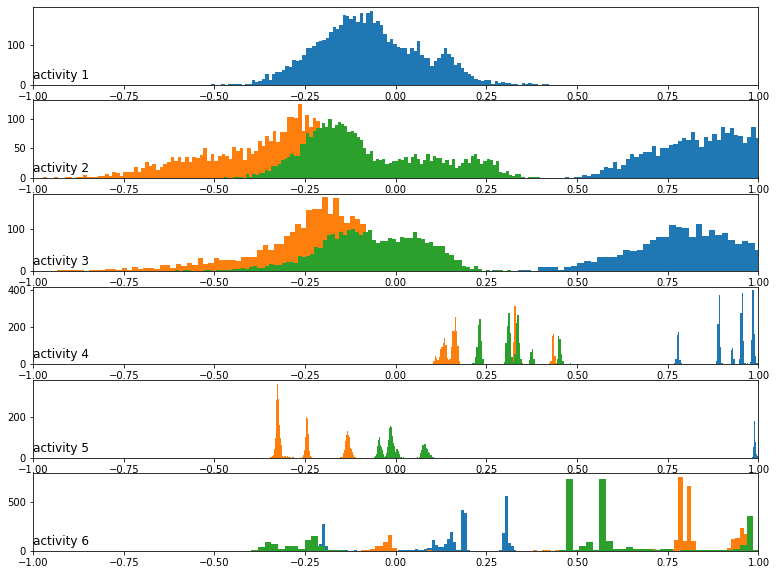

In [13]:
# plot histograms for each activity for a subject
# for  total acceleration data
def plot_activity_histograms(X, y):
    # list of unique activities
    activity = unique(y[:,0])
    # group by activity
    grouped = data_by_activity(X, y, activity)
    # plot per activity
    plt.figure(figsize=(13,10))
    x_axis = None
    for i in range(len(activity)):
        activity_id = activity[i]
        for j in range(3):
            axes_subplot = plt.subplot(len(activity), 1, i+1, sharex=x_axis)
            axes_subplot.set_xlim(-1,1)
            if i == 0:
                x_axis = axes_subplot
            plt.hist(to_series(grouped[activity_id][:,:,j]), bins=100)
            plt.title('activity '+str(activity_id), y=0, loc='left')
    plt.show()

train_subjects = unique(subject_map)
# get the data for one subject
subject_id = train_subjects[0]
subjectDataX, subjectDataY = data_for_subject(X, y, subject_map, subject_id)
# plot data for subject
plot_activity_histograms(subjectDataX, subjectDataY)

<ipython-input-14-4ba499f17941>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes_subplot = plt.subplot(len(activity), 1, i+1, sharex=x_axis)


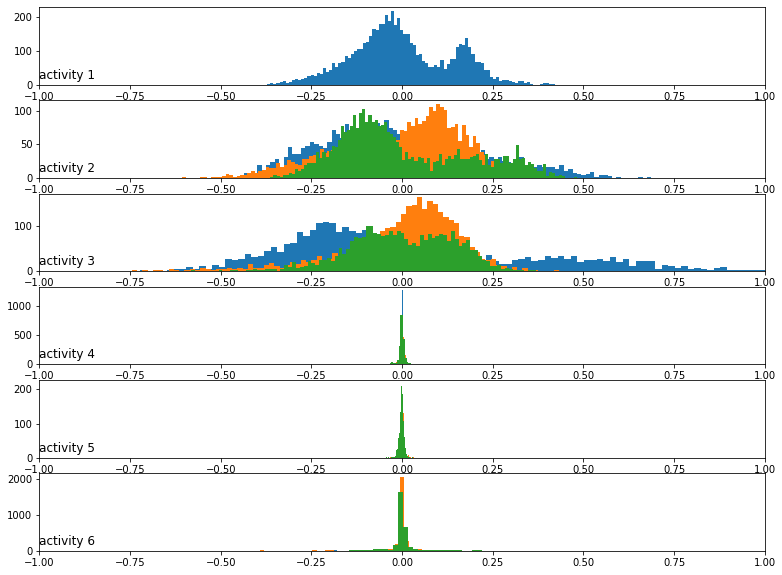

In [14]:
# plot histograms for each activity for a subject
# for body acceleration data
def plot_activity_histograms(X, y):
    # list of unique activities
    activity = unique(y[:,0])
    # group by activity
    grouped = data_by_activity(X, y, activity)
    # plot per activity
    plt.figure(figsize=(13,10))
    x_axis = None
    for i in range(len(activity)):
        activity_id = activity[i]
        for j in range(3):
            axes_subplot = plt.subplot(len(activity), 1, i+1, sharex=x_axis)
            axes_subplot.set_xlim(-1,1)
            if i == 0:
                x_axis = axes_subplot
            plt.hist(to_series(grouped[activity_id][:,:,3+j]), bins=100)
            plt.title('activity '+str(activity_id), y=0, loc='left')
    plt.show()

train_subjects = unique(subject_map)
# get the data for one subject
subject_id = train_subjects[0]
subjectDataX, subjectDataY = data_for_subject(X, y, subject_map, subject_id)
# plot data for subject
plot_activity_histograms(subjectDataX, subjectDataY)

<ipython-input-15-e9ad112aaf28>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes_subplot = plt.subplot(len(activity), 1, i+1, sharex=x_axis)


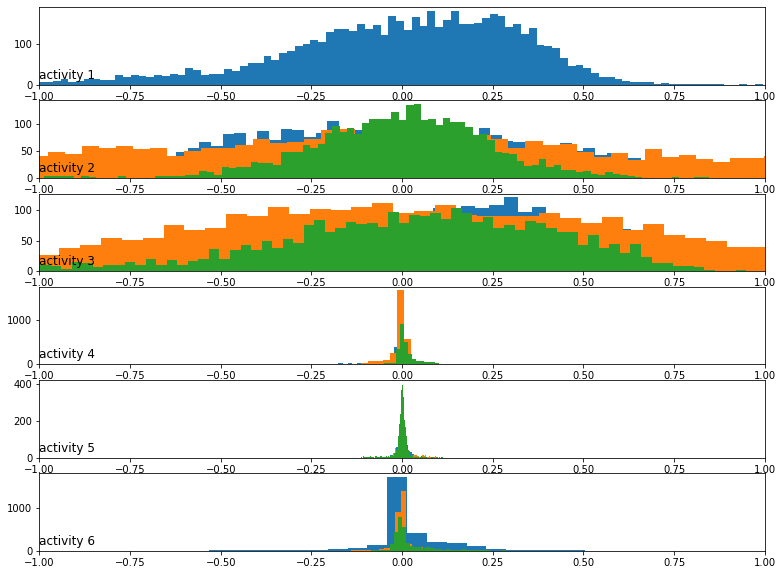

In [15]:
# plot histograms for each activity for a subject
# for gyroscopic data
def plot_activity_histograms(X, y):
    # list of unique activities
    activity = unique(y[:,0])
    # group by activity
    grouped = data_by_activity(X, y, activity)
    # plot per activity
    plt.figure(figsize=(13,10))
    x_axis = None
    for i in range(len(activity)):
        activity_id = activity[i]
        for j in range(3):
            axes_subplot = plt.subplot(len(activity), 1, i+1, sharex=x_axis)
            axes_subplot.set_xlim(-1,1)
            if i == 0:
                x_axis = axes_subplot
            plt.hist(to_series(grouped[activity_id][:,:,6+j]), bins=100)
            plt.title('activity '+str(activity_id), y=0, loc='left')
    plt.show()

train_subjects = unique(subject_map)
# get the data for one subject
subject_id = train_subjects[0]
subjectDataX, subjectDataY = data_for_subject(X, y, subject_map, subject_id)
# plot data for subject
plot_activity_histograms(subjectDataX, subjectDataY)

In [29]:
%%time
## KNN Hyperparameter Tuning

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'n_neighbors': np.arange(1,15), 'p': [1, 2], 
              'weights': ["uniform", "distance"]}

knn_clf = KNeighborsClassifier()

knn_cv = GridSearchCV(knn_clf, param_grid, scoring='f1_micro', cv=5, verbose=3, n_jobs=-1)
knn_cv.fit(x_train_fe, y_train_fe)


params_optimal_knn = knn_cv.best_params_

print("Best Score: %f" % knn_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn)
print("\n")

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:  6.1min finished


Best Score: 0.909416
Optimal Hyperparameter Values:  {'n_neighbors': 13, 'p': 1, 'weights': 'distance'}


CPU times: user 990 ms, sys: 206 ms, total: 1.2 s
Wall time: 6min 7s


In [ ]:
## Decision Tree Classifier Hyperparameter Tuning

In [ ]:
## SVC Hyperparameter Tuning

In [ ]:
## GaussianNB Classifier Hyperparameter Tuning

In [16]:
# A dictionary that will contain all the models that are to be evaluated

model_dict = {
    "knn" : KNeighborsClassifier(n_neighbors=5),
    "dtc" : DecisionTreeClassifier(),
    "svm" : SVC(),
    "bayes" : GaussianNB()
}

print(model_dict)

{'knn': KNeighborsClassifier(), 'dtc': DecisionTreeClassifier(), 'svm': SVC(), 'bayes': GaussianNB()}


In [17]:
## Evaluating the dictionary of models
## For Accuracy

def model_evaluation(x_train, y_train, x_test, y_test, model_dict):
    accuracy = dict()
    for name, model in model_dict.items():
        model.fit(x_train, y_train)
        predict = model.predict(x_test)
        accuracy[name] = (accuracy_score(y_test, predict))*100.00
        print(name,":",accuracy[name])
    return accuracy

In [18]:
# Evaluation for accuracy using the pre-preocessed, feature engineered data
print("Accuracy using pre-preocessed, feature engineered data: ")
accuracy = model_evaluation(x_train_fe, y_train_fe, x_test_fe, y_test_fe, model_dict)


Accuracy using pre-preocessed, feature engineered data: 
knn : 90.15948422124194
dtc : 85.64642008822531
svm : 95.04580929759076
bayes : 77.02748557855446


In [19]:
# Evaluation for accuracy using the pre-preocessed raw data
print("Accuracy using pre-preocessed raw data: ")
accuracy = model_evaluation(x_train_raw, y_train_raw, x_test_raw, y_test_raw, model_dict)


Accuracy using pre-preocessed raw data: 
knn : 65.0492025788938
dtc : 71.36070580251102
svm : 88.73430607397353
bayes : 72.48048863250763


In [20]:
## Evaluating the dictionary of models
## For F1 scores

def model_evaluation_score(x_train, y_train, x_test, y_test, model_dict):
    f1_scores = dict()
    for name, model in model_dict.items():
        model.fit(x_train, y_train)
        predict = model.predict(x_test)
        f1_scores[name] = f1_score(y_test, predict, average='micro')
        print(name,":",f1_scores[name])
    return f1_scores

In [21]:
# Evaluation for f1_score using the pre-preocessed, feature engineered data
print("F1_score using pre-preocessed, feature engineered data: ")
accuracy = model_evaluation_score(x_train_fe, y_train_fe, x_test_fe, y_test_fe, model_dict)

F1_score using pre-preocessed, feature engineered data: 
knn : 0.9015948422124194
dtc : 0.8625721072276892
svm : 0.9504580929759077
bayes : 0.7702748557855447


In [22]:
# Evaluation for f1_score using the pre-preocessed raw data
print("F1_score using pre-preocessed raw data: ")
accuracy = model_evaluation_score(x_train_raw, y_train_raw, x_test_raw, y_test_raw, model_dict)

F1_score using pre-preocessed raw data: 
knn : 0.6504920257889379
dtc : 0.7224295894129623
svm : 0.8873430607397353
bayes : 0.7248048863250763
